# Convolutional Neural Networks

**Image Classification** is another interesting topic of machine learning. It involves teaching a machine to see and interpret the content of visual data, much like we previously taught models to understand the sentiment of text.

To tackle this visual challenge, we need a new kind of architecture. The star of this show is the **Convolutional Neural Network (CNN)**, an architecture specifically designed to understand and interpret visual information. Unlike our previous text-based models, it excels at recognizing patterns and hierarchical features directly from pixel data. 

Our humble goal here is to build a simple CNN, understand its fundamental components, and train it to distinguish between ten different categories of everyday objects using a relatively small dataset.

## Data Preparation

For this task, we are going to use a [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, which is conveniently available through Keras. It consists of 60,000 images in 10 classes, with 6,000 images per class. 

In [1]:
from datasets import load_dataset
import numpy as np

train, test = load_dataset('uoft-cs/cifar10', split=['train', 'test'])
class_names = train.features['label'].names

x_train = np.array(train['img'])
y_train = np.array(train['label'])
x_test = np.array(test['img'])
y_test = np.array(test['label'])

Let's visualize a few training images to get a feel for the data.

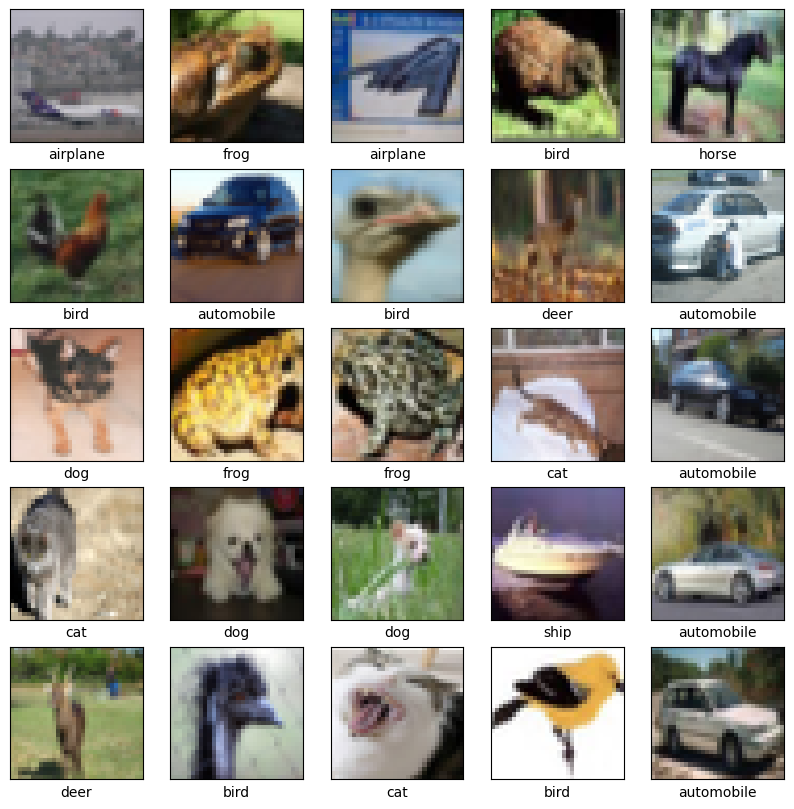

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10, 10])

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i]])

plt.show()

From a technical perspective, each sample (image) is a 32x32 grid of pixels, each encoded using [three RGB channels](https://en.wikipedia.org/wiki/RGB_color_model) (with their values ranging from 0 to 255). It may be an issue because features with larger numerical values may disproportionately influence the model's weight updates. Therefore, normalizing them to a smaller range (commonly 0 to 1) would be a good idea.

In [3]:
import numpy as np
x_train = np.array([np.array(x) for x in x_train]).astype('float32') / 255.0
x_test = np.array([np.array(x) for x in x_test]).astype('float32') / 255.0

## Building and Training the Model

Now, let's construct our CNN. 

That type of neural network is particularly well-suited for image data because it uses specialized layers to automatically and adaptively learn spatial hierarchies of features – from edges and textures in earlier layers to more complex patterns and object parts in deeper layers.

Our architecture will consist of two sequential sub-models:

- **Feature Learning:** The eyes of the network. This part is responsible for taking the raw pixel data from the image and gradually extracting increasingly complex and abstract visual patterns. Much like how your own visual cortex detects edges, textures, and simple shapes before your brain starts to assemble them into recognizable objects. This is achieved by flowing data through multiple similar stages:

    - **Convolutional Layer:** This is the core feature detector. It applies a set of learnable filters (kernels) to the input image. Each filter slides across the image, performing a convolution operation to detect specific features like edges, corners, or textures. Early layers might detect simple lines, while deeper ones combine those into more complex shapes like corners or curves.

    - **Max Pooling Layer:** After a convolutional layer has identified a bunch of features, max pooling helps to generalize and condense this information. It looks at small windows of the feature map and picks out the strongest response (the max value). This makes the learned features more robust to variations and greatly reduces computational complexity.

- **Classification:** The brain of the network. Once the feature learning part has extracted a rich set of abstract features from the image, this sub-model takes those high-level features and makes a decision about what object the image contains. Conceptually, it's very close to our [Multilayer Perceptron](sentiment/03-mlp.ipynb) attempt, but this time it classifies visual clues instead of words.

In [4]:
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras import layers, Sequential
set_random_seed(0)

feature_learning = Sequential(name='feature_learning', layers=[
    layers.Input(shape=x_train.shape[1:]),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
])

classification = Sequential(name='classification', layers=[
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax'),
])

model = Sequential([
    feature_learning,
    classification,
])

display(model.summary(expand_nested=True))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_learning (Sequential)   │ (None, 4, 4, 128)      │        93,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2d (Conv2D)            │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ max_pooling2d              │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2d_1 (Conv2D)          │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ max_pooling2d_1            │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv2d_2 (Conv2D)          │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ max_pooling2d_2            │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Sequential)     │ (None, 10)             │       263,562 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ flatten (Flatten)          │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense (Dense)              │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dropout (Dropout)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_1 (Dense)            │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

None

Let's train our model now. We may revert back to CPU usage - our model is yet relatively small.

In [5]:
from tensorflow import device
with device('/CPU'):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=25, batch_size=64, validation_split=0.2)

Epoch 1/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.2833 - loss: 1.9243 - val_accuracy: 0.4893 - val_loss: 1.3676
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.4947 - loss: 1.4071 - val_accuracy: 0.5787 - val_loss: 1.1928
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.5790 - loss: 1.1937 - val_accuracy: 0.6389 - val_loss: 1.0099
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.6236 - loss: 1.0644 - val_accuracy: 0.6721 - val_loss: 0.9262
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.6587 - loss: 0.9777 - val_accuracy: 0.6783 - val_loss: 0.9039
Epoch 6/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.6896 - loss: 0.8862 - val_accuracy: 0.7021 - val_loss: 0.8382
Epoch 7/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.7100 - loss: 0.8196 - val_accuracy: 0.6927 - val_loss: 0.8815
Epoch 8/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.7312 - loss: 0.7711 - 

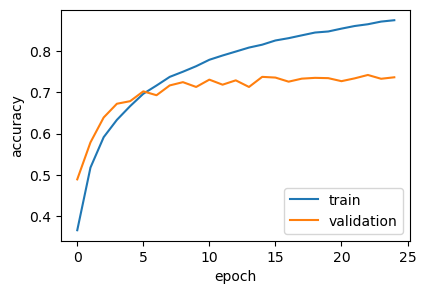

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4.5, 3))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

## Result

In [7]:
from sklearn.metrics import classification_report
with device('/CPU'):
    y_pred_values = model.predict(x_test, verbose=False)
    y_pred_labels = np.argmax(y_pred_values, axis=1)
    print(classification_report(y_test, y_pred_labels, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.76      0.80      0.78      1000
  automobile       0.88      0.81      0.85      1000
        bird       0.66      0.59      0.62      1000
         cat       0.54      0.53      0.54      1000
        deer       0.66      0.73      0.70      1000
         dog       0.65      0.62      0.64      1000
        frog       0.78      0.81      0.80      1000
       horse       0.76      0.80      0.78      1000
        ship       0.86      0.84      0.85      1000
       truck       0.81      0.82      0.81      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



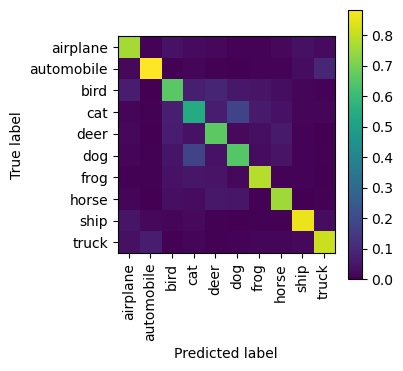

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
_, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_labels, 
    display_labels=class_names, 
    normalize='pred',
    xticks_rotation='vertical',
    include_values=False, 
    ax=ax
)

## Conclusion

With a respectable **74% accuracy** on the CIFAR-10 test set, our relatively straightforward CNN has demonstrated its ability to learn meaningful visual features and classify images, even without extensive tuning or advanced architectures. 

This experiment demonstrates how convolutional and pooling layers work together to extract hierarchical patterns, and how a dense classifier can then make sense of these learned features.

Looking at the training history, we can observe the training accuracy steadily increasing. However, the validation accuracy appears to plateau or slightly decrease in later epochs, suggesting that the model is starting to overfit the training data. This suggests a clear need for data augmentation and regularization (batch normalization, more dropouts) to combat this and potentially improve generalization.